<a href="https://colab.research.google.com/github/allefbcc/projetoCienciaDeDados-Walmart/blob/main/forecasting-notebook-group-6/N4_forecasting_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão do Total de vendas em cada Loja.

## Importanto bibliotecas

In [ ]:
!pip install mlforecast
!pip install dill

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
from mlforecast.target_transforms import LocalMinMaxScaler
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import dill as pickle
import tempfile
import os

## Carregando DataFrame

In [ ]:
bucket_ur = "gs://m5_dados/M5_full.parquet"

In [ ]:
data = pd.read_parquet(bucket_ur)

In [ ]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,value,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,2016-05-22


In [ ]:
data_lojas = data[['date', 'store_id', 'value']]

In [ ]:
data_lojas

,date,store_id,value
0,2011-01-29,CA_1,0
1,2011-01-29,CA_1,0
2,2011-01-29,CA_1,0
3,2011-01-29,CA_1,0
4,2011-01-29,CA_1,0
...,...,...,...
59181085,2016-05-22,WI_3,1
59181086,2016-05-22,WI_3,0
59181087,2016-05-22,WI_3,2
59181088,2016-05-22,WI_3,0


In [ ]:
data_lojas['date'] = pd.to_datetime(data_lojas['date'])

/var/tmp/ipykernel_54652/1325666363.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lojas['date'] = pd.to_datetime(data_lojas['date'])


In [ ]:
data_lojas.set_index('date', inplace=True)

In [ ]:
data_lojas

,store_id,value
date,,
2011-01-29,CA_1,0
2011-01-29,CA_1,0
2011-01-29,CA_1,0
2011-01-29,CA_1,0
2011-01-29,CA_1,0
...,...,...
2016-05-22,WI_3,1
2016-05-22,WI_3,0
2016-05-22,WI_3,2


## Agrupando dados por Loja

In [ ]:
data_lojas = (data_lojas
                        .groupby('store_id')
                        .resample('D')
                        .sum()
                        .reset_index())

/var/tmp/ipykernel_54652/1294785960.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('store_id')


In [ ]:
data_lojas

,store_id,date,value
0,CA_1,2011-01-29,4337
1,CA_1,2011-01-30,4155
2,CA_1,2011-01-31,2816
3,CA_1,2011-02-01,3051
4,CA_1,2011-02-02,2630
...,...,...,...
19405,WI_3,2016-05-18,3268
19406,WI_3,2016-05-19,3398
19407,WI_3,2016-05-20,4126
19408,WI_3,2016-05-21,4519


## Transformando dados no padrão NIXTLA

In [ ]:
data_lojas =  data_lojas.rename(columns={'date': 'ds', 'value': 'y', 'store_id': 'unique_id'})

In [ ]:
data_lojas

,unique_id,ds,y
0,CA_1,2011-01-29,4337
1,CA_1,2011-01-30,4155
2,CA_1,2011-01-31,2816
3,CA_1,2011-02-01,3051
4,CA_1,2011-02-02,2630
...,...,...,...
19405,WI_3,2016-05-18,3268
19406,WI_3,2016-05-19,3398
19407,WI_3,2016-05-20,4126
19408,WI_3,2016-05-21,4519


## Separação dos dados em treinamento e teste

In [ ]:
train_list = []
test_list = []

# Dividindo o dataframe por estado e aplicando a divisão 80/20
for state in data_lojas['unique_id'].unique():
    state_data = data_lojas[data_lojas['unique_id'] == state]
    train, test = train_test_split(state_data, test_size=0.2, shuffle=False) # shuffle=False mantém a ordem temporal
    train_list.append(train)
    test_list.append(test)

In [ ]:
data_train = pd.concat(train_list)
data_test = pd.concat(test_list)

# Resetando os índices dos dataframes resultantes
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [ ]:
data_train

,unique_id,ds,y
0,CA_1,2011-01-29,4337
1,CA_1,2011-01-30,4155
2,CA_1,2011-01-31,2816
3,CA_1,2011-02-01,3051
4,CA_1,2011-02-02,2630
...,...,...,...
15515,WI_3,2015-04-25,3444
15516,WI_3,2015-04-26,3467
15517,WI_3,2015-04-27,2520
15518,WI_3,2015-04-28,2326


In [ ]:
data_test

,unique_id,ds,y
0,CA_1,2015-04-30,3466
1,CA_1,2015-05-01,5121
2,CA_1,2015-05-02,5801
3,CA_1,2015-05-03,6524
4,CA_1,2015-05-04,4794
...,...,...,...
3885,WI_3,2016-05-18,3268
3886,WI_3,2016-05-19,3398
3887,WI_3,2016-05-20,4126
3888,WI_3,2016-05-21,4519


In [ ]:
data_full = pd.concat([data_train, data_test])

## Analisando o grafico de autocorrelação

In [ ]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

ACF e PACF para o estado: CA_1


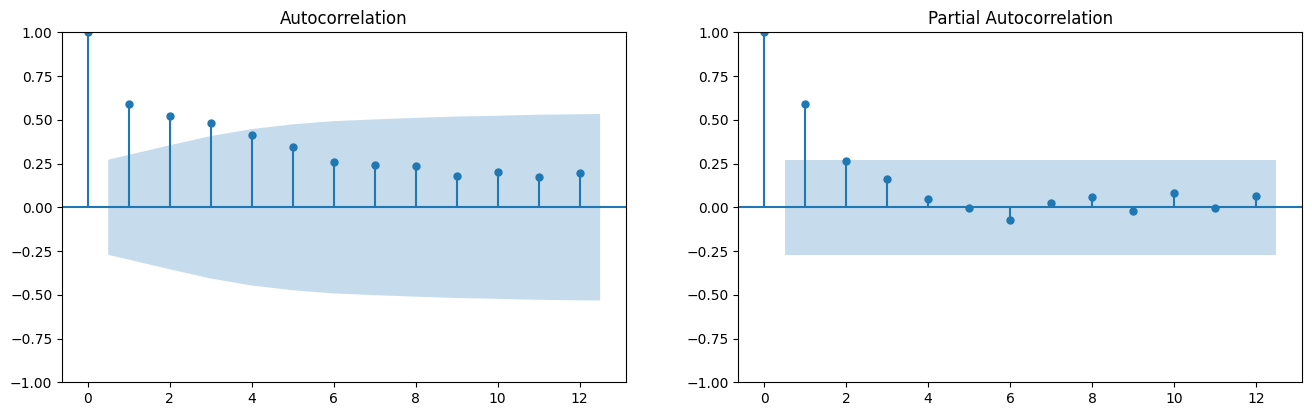

ACF e PACF para o estado: CA_2


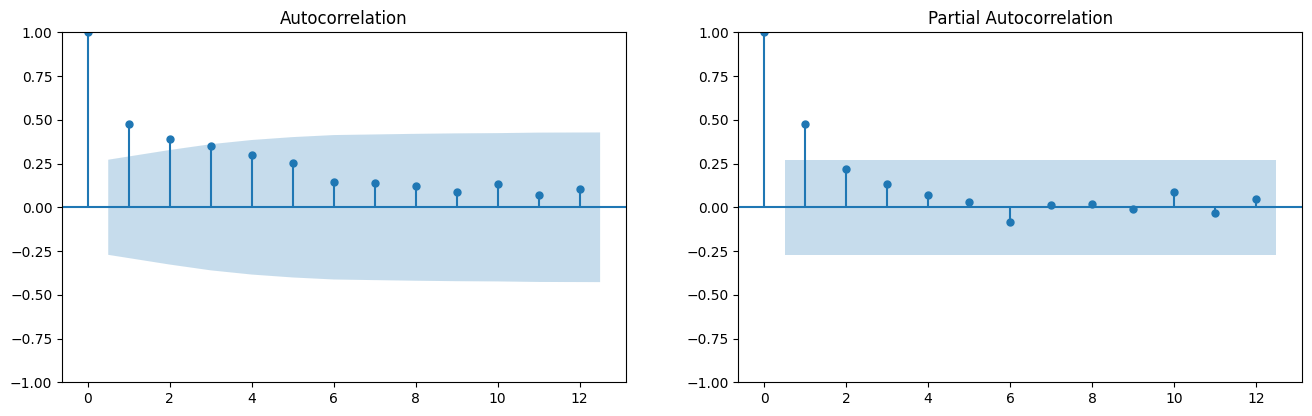

ACF e PACF para o estado: CA_3


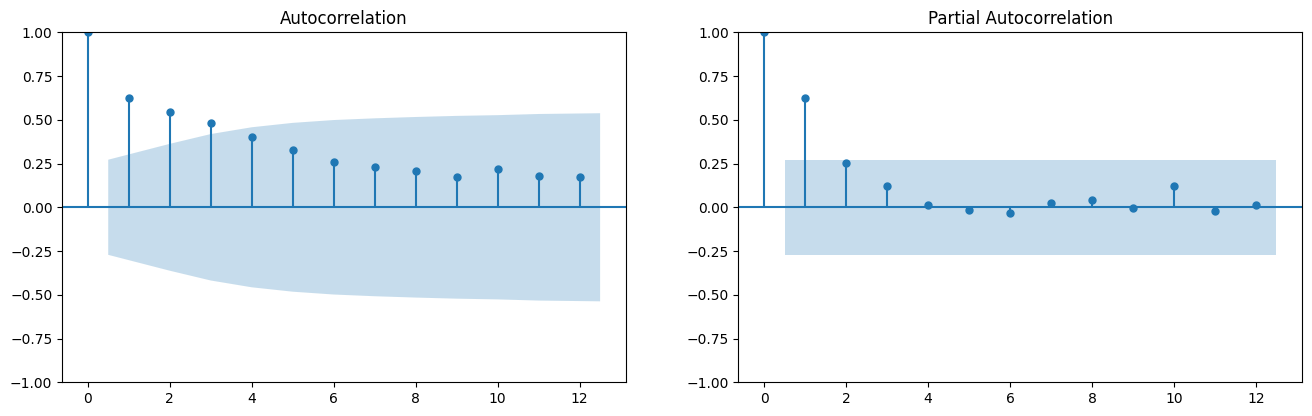

ACF e PACF para o estado: CA_4


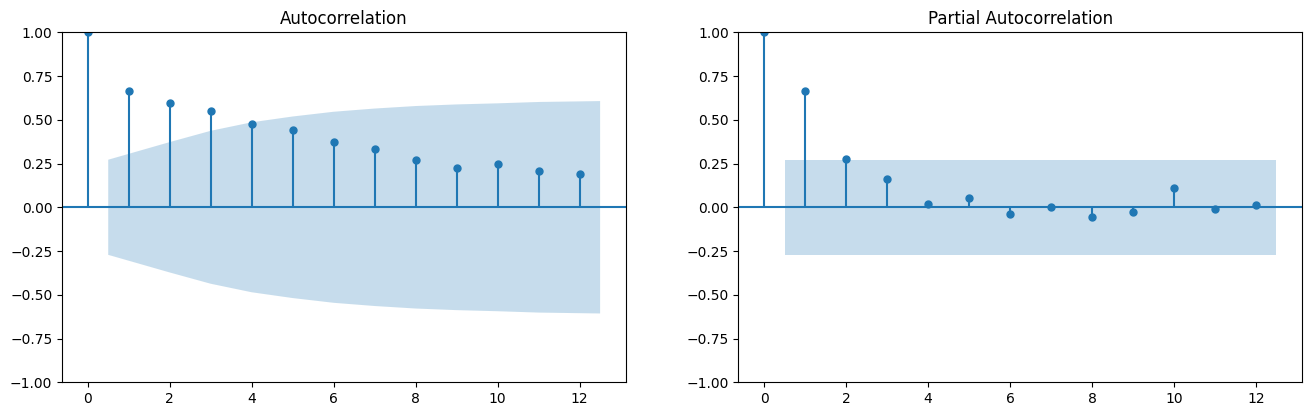

ACF e PACF para o estado: TX_1


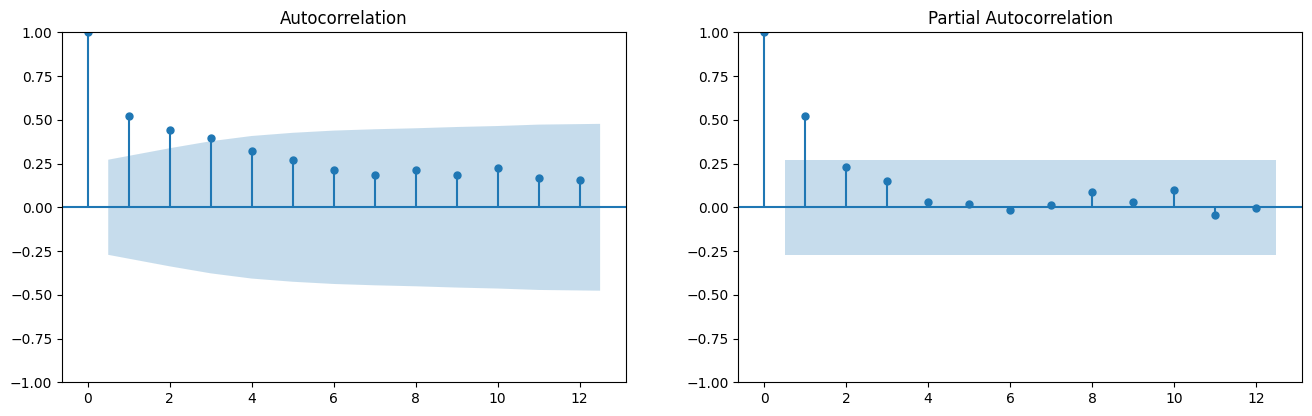

ACF e PACF para o estado: TX_2


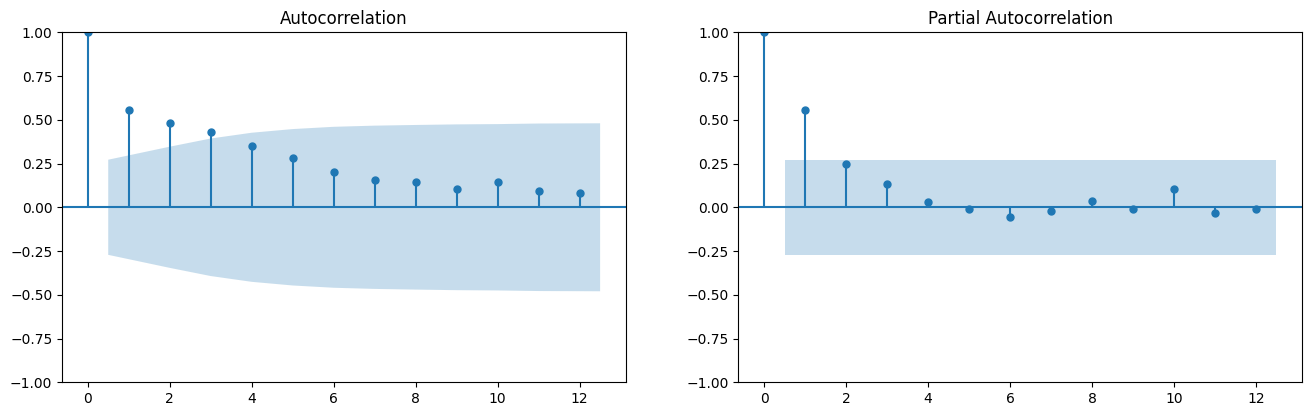

ACF e PACF para o estado: TX_3


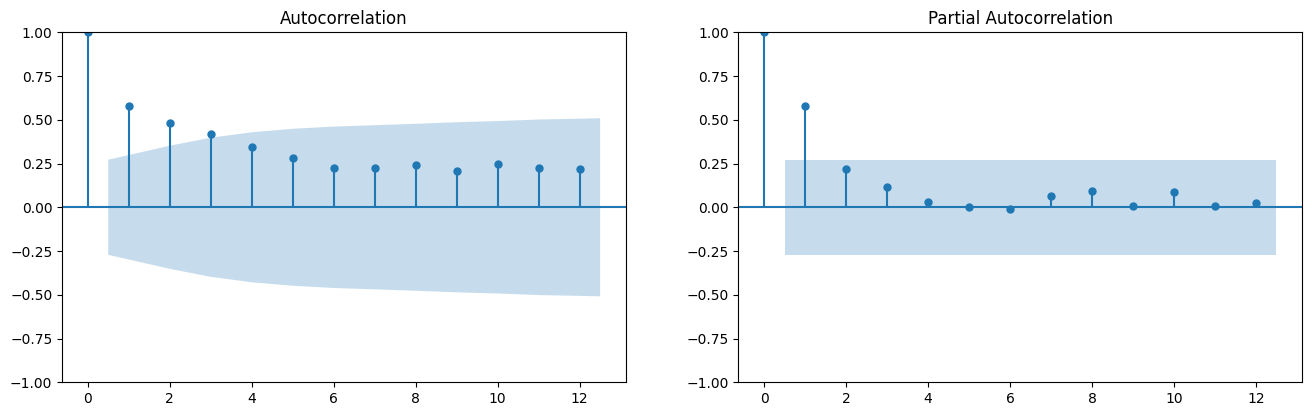

ACF e PACF para o estado: WI_1


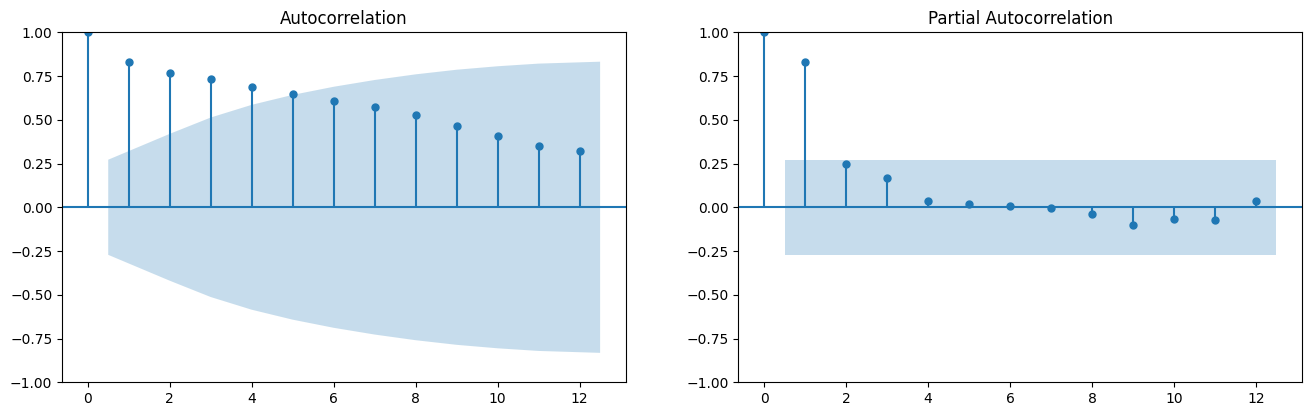

ACF e PACF para o estado: WI_2


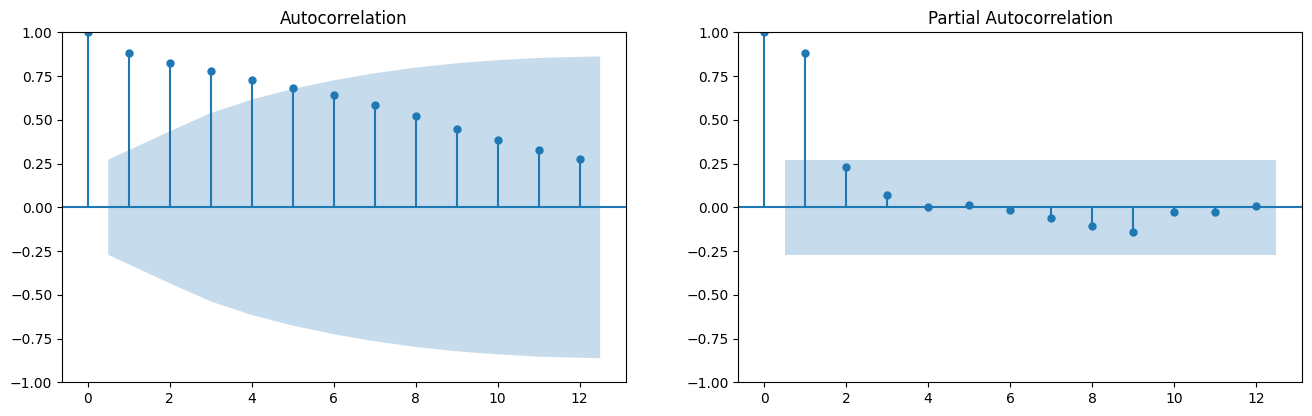

ACF e PACF para o estado: WI_3


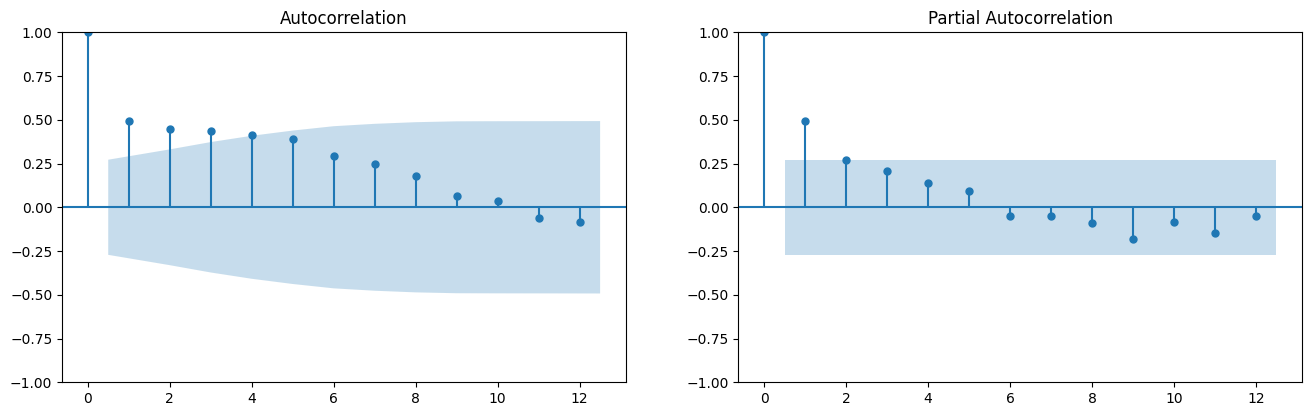

In [ ]:
for state in data_train['unique_id'].unique():
    state_df = data_train[data_train['unique_id'] == state]
    print(f"ACF e PACF para o estado: {state}")
    acf_pacf(state_df['y'], 30)

## Treinamento e previsão do modelo

In [ ]:
models = [
    RandomForestRegressor(n_estimators=50, random_state=0),
    KNeighborsRegressor(n_neighbors=3),
]

In [ ]:
mlf = MLForecast(
    models=models,
    freq='D',
    target_transforms=[LocalMinMaxScaler()],
    lags=[90]
)
mlf.fit(data_train)

MLForecast(models=[RandomForestRegressor, KNeighborsRegressor], freq=D, lag_features=['lag90'], date_features=[], num_threads=1)

In [ ]:
forecasts = mlf.predict(395)

In [ ]:
data_test = data_test.merge(forecasts, how='left', on=['unique_id', 'ds'])

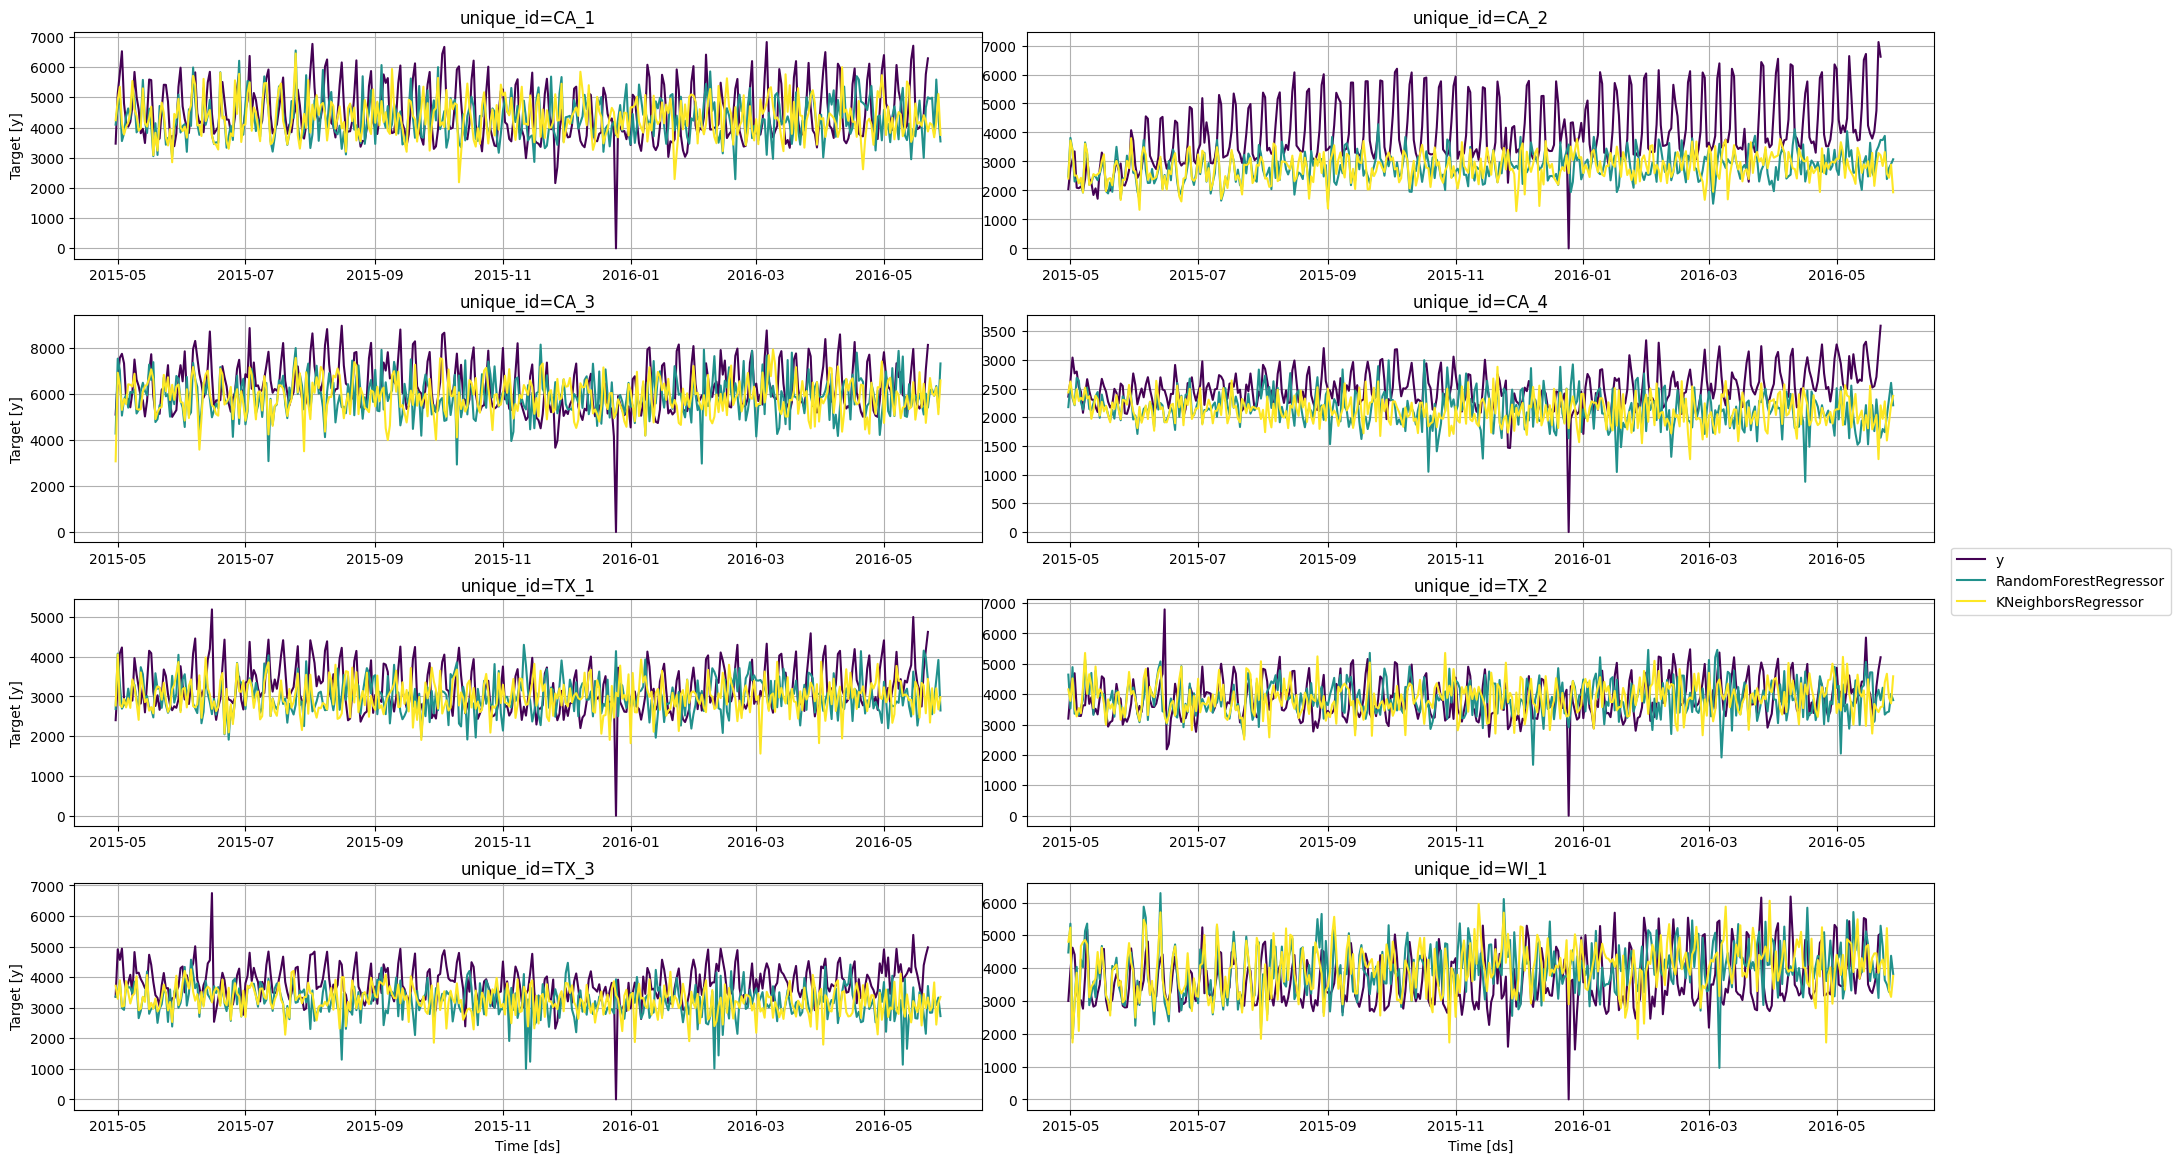

In [ ]:
plot_series(data_test, forecasts, plot_random=False)

In [ ]:
data_test

,unique_id,ds,y,RandomForestRegressor,KNeighborsRegressor
0,CA_1,2015-04-30,3466,4095.145752,4240.609375
1,CA_1,2015-05-01,5121,4697.659180,4898.420410
2,CA_1,2015-05-02,5801,5046.133789,5347.775391
3,CA_1,2015-05-03,6524,3552.182617,4145.114258
4,CA_1,2015-05-04,4794,3806.086182,3769.468994
...,...,...,...,...,...
3885,WI_3,2016-05-18,3268,4222.856445,3090.698975
3886,WI_3,2016-05-19,3398,1630.695801,3690.417725
3887,WI_3,2016-05-20,4126,3121.647217,4409.822266
3888,WI_3,2016-05-21,4519,1685.087036,3781.302979


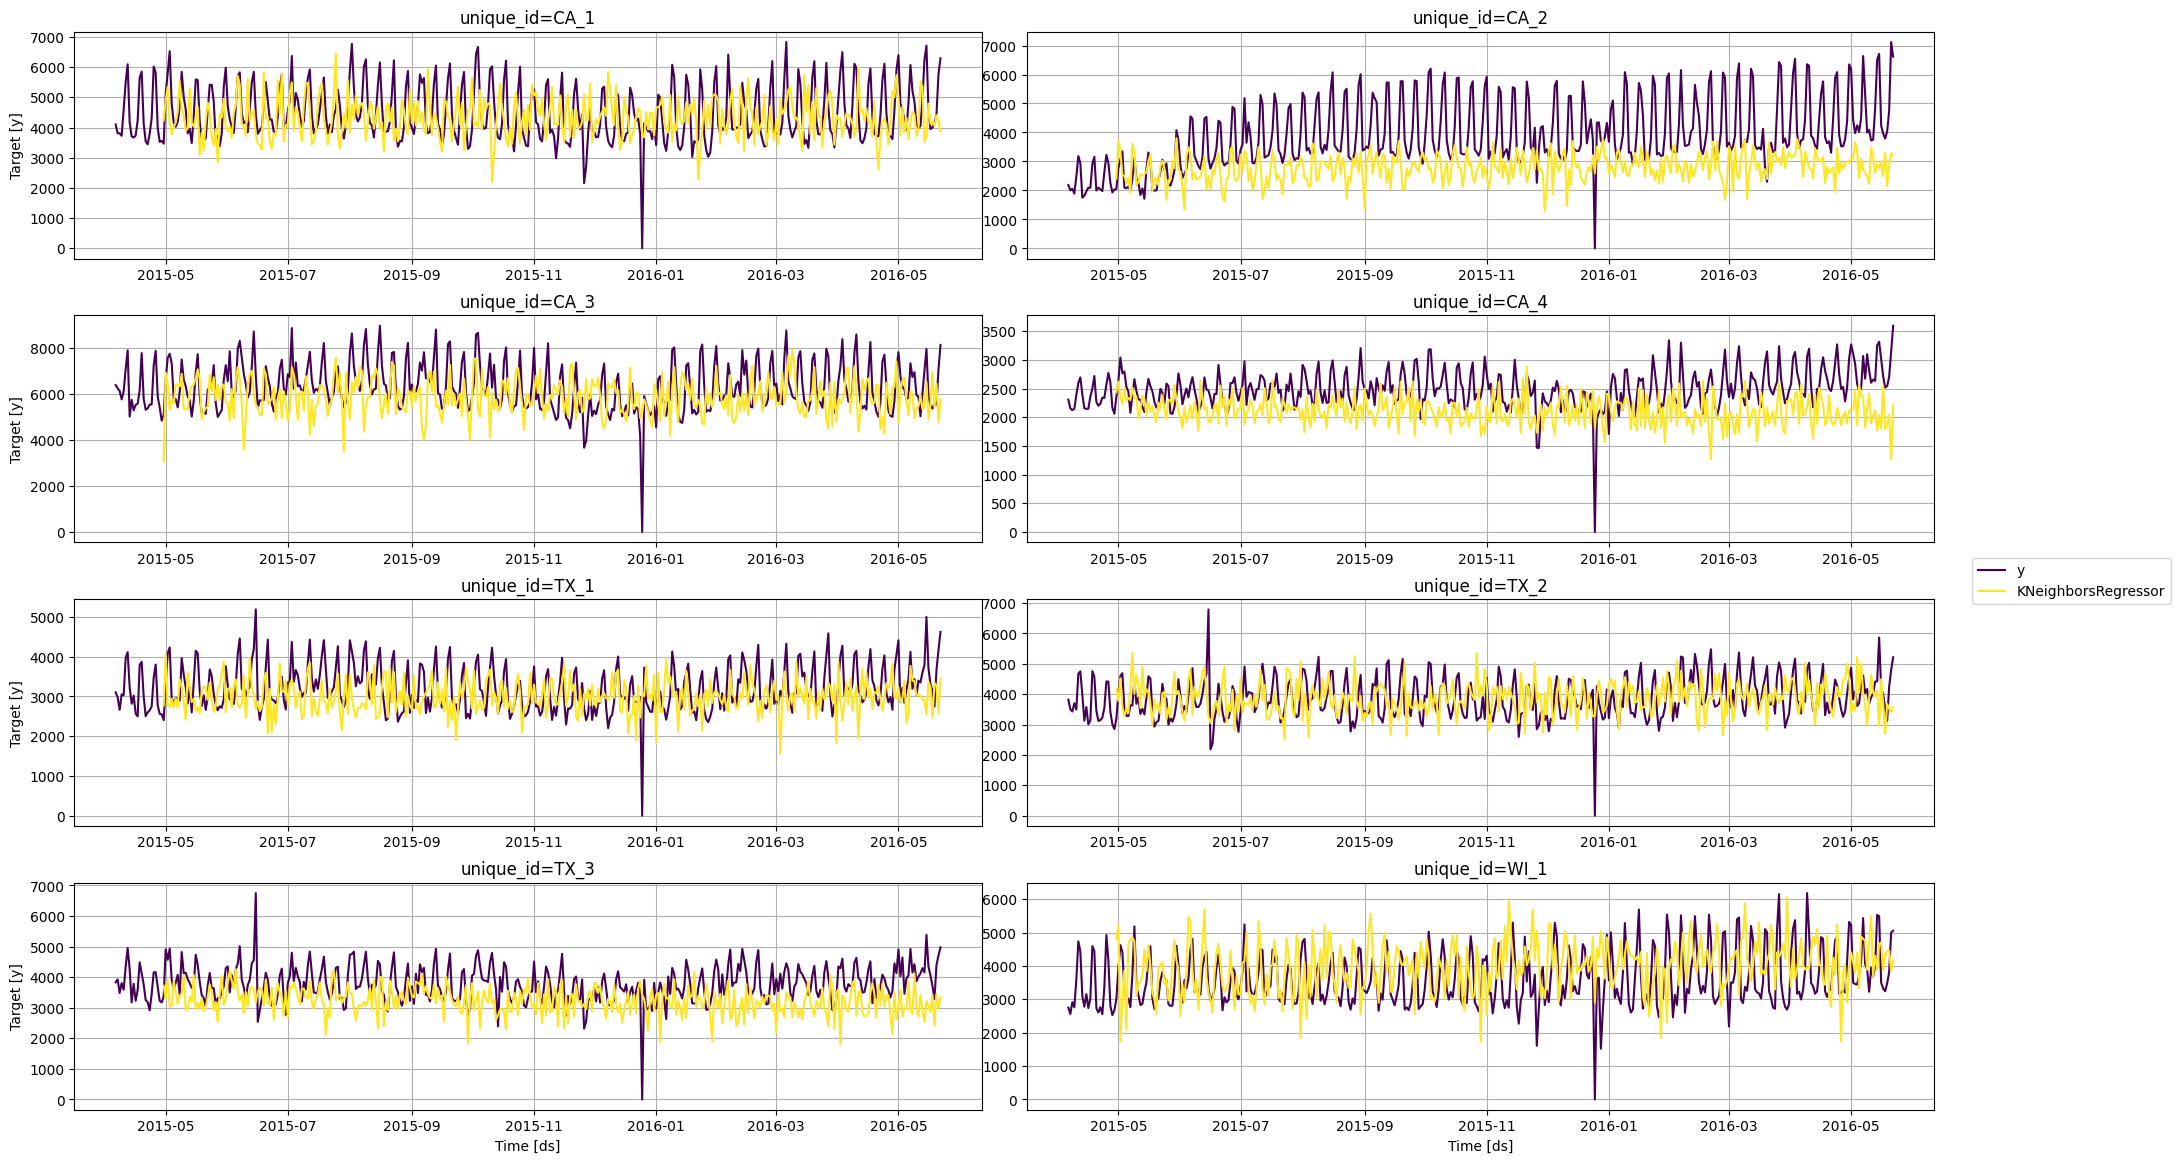

In [ ]:
fig = plot_series(
    data_train,
    data_test,
    plot_random=False,
    models=['KNeighborsRegressor'],
    max_insample_length=24
)
fig

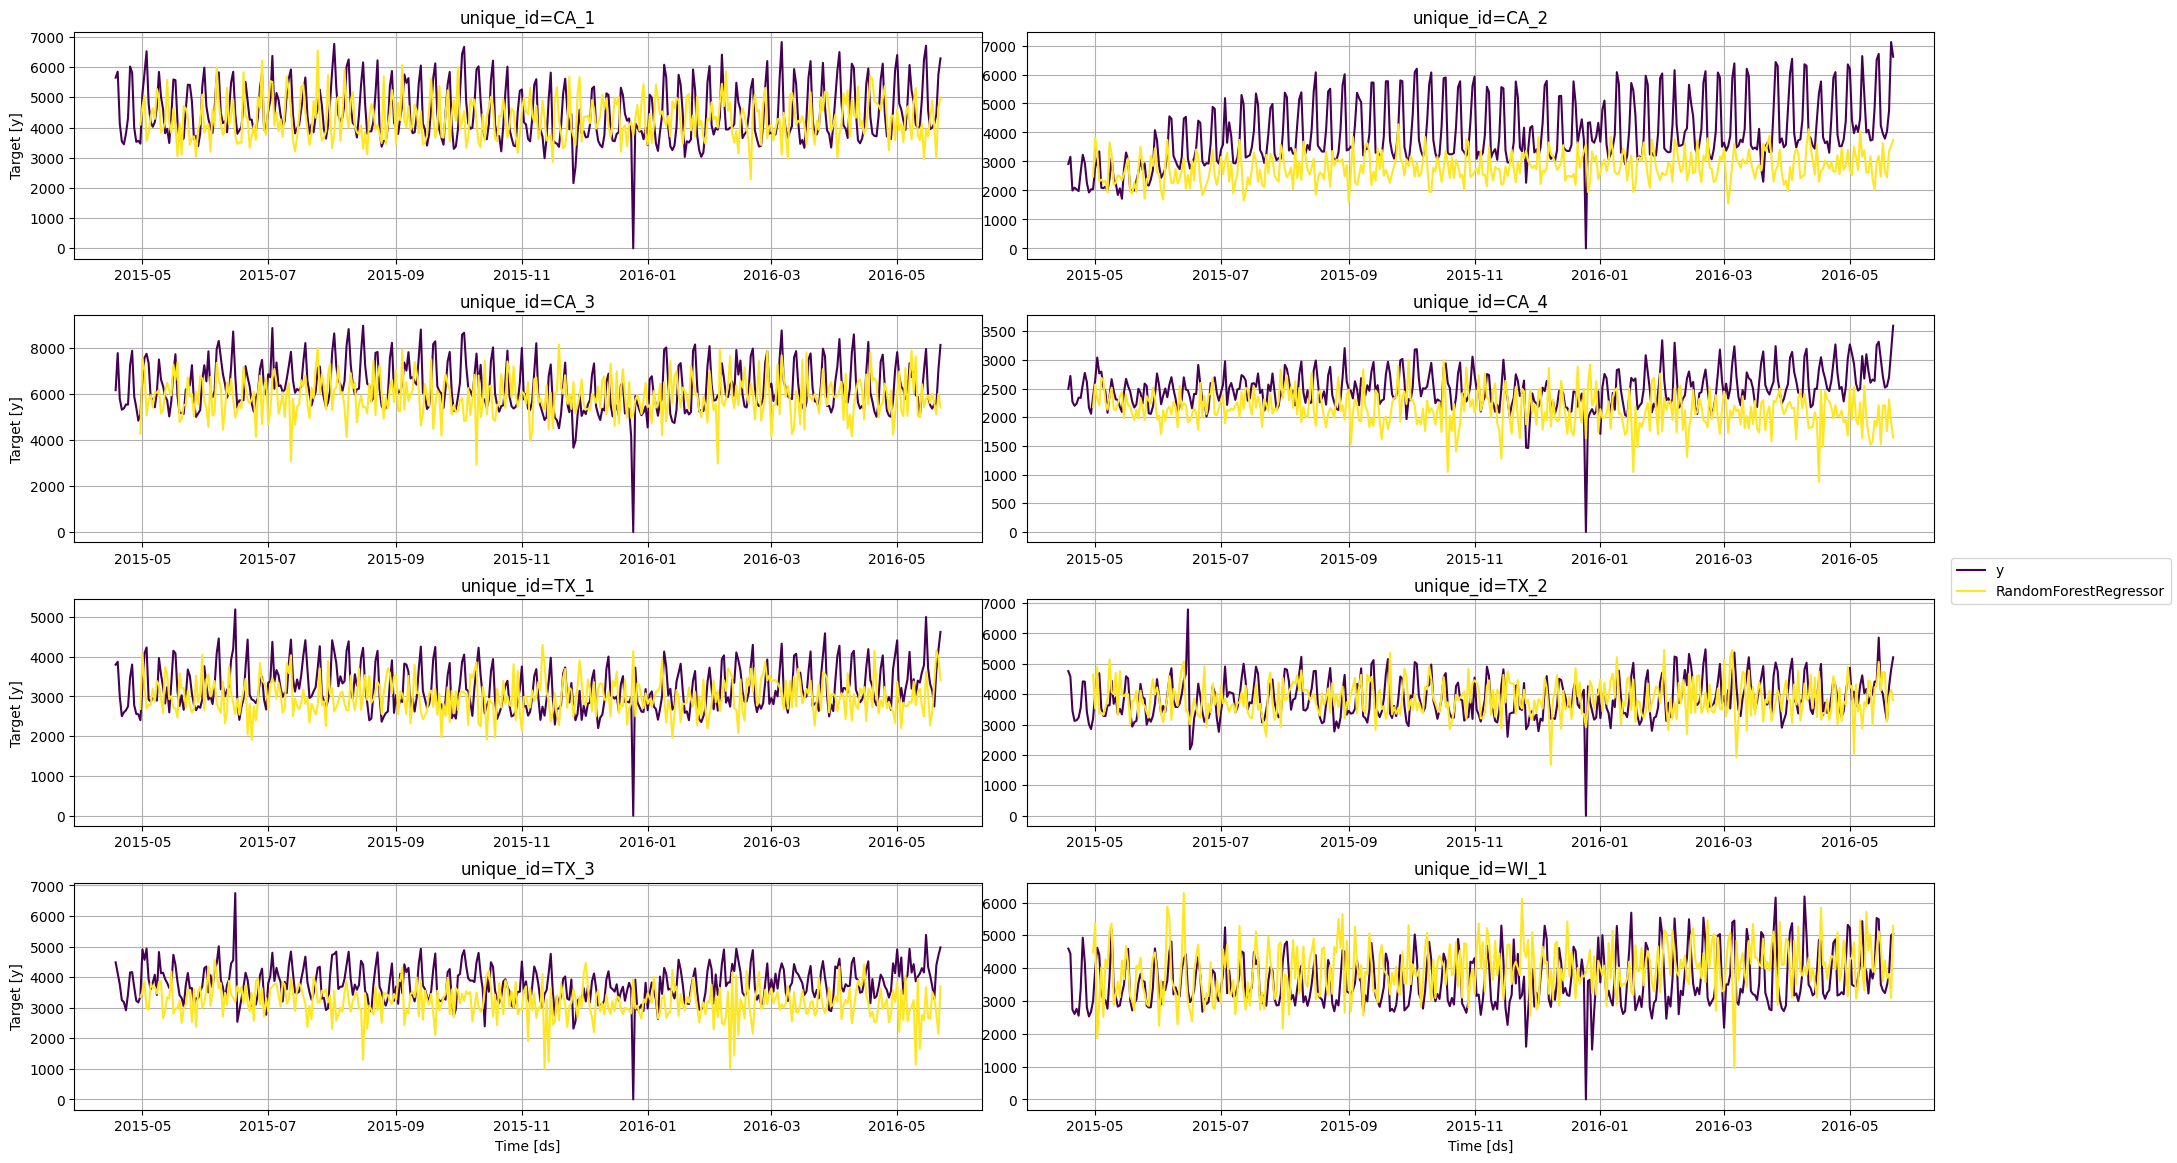

In [ ]:
fig = plot_series(
    data_train,
    data_test,
    plot_random=False,
    models=['RandomForestRegressor'],
    max_insample_length=12
)
fig

In [ ]:
metrics = []

# Calcular as métricas para cada unique_id
unique_ids = data_test['unique_id'].unique()
for unique_id in unique_ids:
    subset = data_test[data_test['unique_id'] == unique_id]
    y_true = subset['y']

    # Previsões do RandomForestRegressor
    y_pred_rf = subset['RandomForestRegressor']
    mae_rf = mean_absolute_error(y_true, y_pred_rf)
    mse_rf = mean_squared_error(y_true, y_pred_rf)
    r2_rf = r2_score(y_true, y_pred_rf)
    mape_rf = MAPE(y_true, y_pred_rf)

    # Previsões do KNeighborsRegressor
    y_pred_knn = subset['KNeighborsRegressor']
    mae_knn = mean_absolute_error(y_true, y_pred_knn)
    mse_knn = mean_squared_error(y_true, y_pred_knn)
    r2_knn = r2_score(y_true, y_pred_knn)
    mape_knn = MAPE(y_true, y_pred_knn)

    # Adicionar métricas ao dataframe
    metrics.append({
        'unique_id': unique_id,
        'MAE_RF': mae_rf,
        'MSE_RF': mse_rf,
        'R2_RF': r2_rf,
        'MAPE_RF': mape_rf,
        'MAE_KNN': mae_knn,
        'MSE_KNN': mse_knn,
        'R2_KNN': r2_knn,
        'MAPE_KNN': mape_knn
    })

# Criar um DataFrame com as métricas
metrics_df = pd.DataFrame(metrics)

# Exibir o DataFrame
metrics_df

,unique_id,MAE_RF,MSE_RF,R2_RF,MAPE_RF,MAE_KNN,MSE_KNN,R2_KNN,MAPE_KNN
0,CA_1,891.904297,1.259074e+06,-0.507879,4.328274e+16,881.992065,1.262786e+06,-0.512324,4.391444e+16
1,CA_2,1278.037476,2.813383e+06,-1.232988,4.887393e+00,1256.943726,2.750380e+06,-1.182983,3.611462e+00
2,CA_3,1058.313354,1.892296e+06,-0.741463,3.457931e+00,1023.069702,1.778958e+06,-0.637158,3.486743e+00
3,CA_4,455.325562,3.379376e+05,-2.065793,1.892251e+16,457.347198,3.124923e+05,-1.834951,2.096563e+16
4,TX_1,581.731140,5.664314e+05,-0.757620,1.081344e+01,581.656494,5.405721e+05,-0.677379,8.125406e+00
5,TX_2,622.779663,6.478648e+05,-0.463533,3.372290e+16,647.894348,6.810121e+05,-0.538413,3.814232e+16
6,TX_3,767.664978,9.966799e+05,-1.863924,3.556922e+00,724.395264,8.364037e+05,-1.403376,3.098810e+00
7,WI_1,915.796814,1.300050e+06,-0.990734,5.242269e+00,932.802856,1.322637e+06,-1.025320,3.999709e+00
8,WI_2,1060.813599,1.903455e+06,-0.812662,7.604067e+00,1048.903564,1.907450e+06,-0.816467,9.257298e+00
9,WI_3,794.149353,1.011764e+06,-0.747585,6.416438e+00,698.534119,7.803624e+05,-0.347893,9.145247e+00


## Previsão 6 meses

In [ ]:
mlf_full = MLForecast(
    models=models,
    freq='D',
    target_transforms=[LocalMinMaxScaler()],
    lags=[90]
)
mlf_full.fit(data_full)

MLForecast(models=[RandomForestRegressor, KNeighborsRegressor], freq=D, lag_features=['lag90'], date_features=[], num_threads=1)

In [ ]:
previsao_6meses = mlf_full.predict(180)

In [ ]:
previsao_6meses

,unique_id,ds,RandomForestRegressor,KNeighborsRegressor
0,CA_1,2016-05-23,4064.789307,4212.850586
1,CA_1,2016-05-24,3200.544922,3437.551025
2,CA_1,2016-05-25,4002.991943,4420.405273
3,CA_1,2016-05-26,3312.070557,3417.880615
4,CA_1,2016-05-27,4673.091309,4681.321777
...,...,...,...,...
1795,WI_3,2016-11-14,3250.346924,3535.246826
1796,WI_3,2016-11-15,3468.149170,3949.313232
1797,WI_3,2016-11-16,4092.167969,4489.311523
1798,WI_3,2016-11-17,4376.226074,3717.653320


## Exportando pkl

In [ ]:
with open('ModelosPKL/vendas_Loja.pkl', 'wb') as f:
    pickle.dump(mlf_full, f)

## Exportando previsão 6 meses

In [ ]:
previsao_6meses.to_csv('Previsoes/previsao_vendas_Loja.csv', index=False)